In [1]:
#Oppgave 2
import requests
import pandas as pd
import json
from pandasql import sqldf

# Henter inn dataen
API_URL = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
headers = {"User-Agent": "MyWeatherApp/1.0 (contact@example.com)", "Accept": "application/json"}
params = {"lat": 59.91, "lon": 10.75}  # Oslo koordinater

response = requests.get(API_URL, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
    with open("../data/weather_data.json", "w") as f:
        json.dump(data, f, indent=4)
    print("Data hentet og lagret som JSON")
else:
    print("Feil ved henting av data! Statuskode:", response.status_code)
    exit()

#Behandler data med Pandas
timeseries = data["properties"]["timeseries"]
rows = []

for entry in timeseries:
    time = entry["time"]
    details = entry["data"]["instant"]["details"]
    rows.append({"Tidspunkt": time, **details})

df = pd.DataFrame(rows)

#Oversetter til norsk
column_mapping = {
    "air_pressure_at_sea_level": "Lufttrykk ved havnivå",
    "air_temperature": "Lufttemperatur",
    "wind_speed": "Vindhastighet",
    "wind_from_direction": "Vindretning",
    "relative_humidity": "Relativ fuktighet",
    "cloud_area_fraction": "Skydekke"
}
df.rename(columns=column_mapping, inplace=True)

df.to_csv("../data/weather_data.csv", index=False)
print("Data lagret som CSV")

#Vurdering av kilde
source_info = {
    "Kilde": "MET Norway",
    "Pålitelighet": "Høy",
    "Tilgjengelighet": "Åpen tilgang, krever User-Agent header",
    "Format": "JSON",
    "Oppdateringsfrekvens": "Løpende oppdateringer",
}
print("Vurdering av kilde:")
for key, value in source_info.items():
    print(f"{key}: {value}")

#Data analyse med PandaSQL
pysqldf = lambda q: sqldf(q, globals())
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM df
WHERE Lufttemperatur IS NOT NULL
ORDER BY Tidspunkt ASC
LIMIT 5;
"""
result = pysqldf(query)
print("\nEksempel på analyserte data:")
print(result)



Data hentet og lagret som JSON
Data lagret som CSV
Vurdering av kilde:
Kilde: MET Norway
Pålitelighet: Høy
Tilgjengelighet: Åpen tilgang, krever User-Agent header
Format: JSON
Oppdateringsfrekvens: Løpende oppdateringer

Eksempel på analyserte data:
              Tidspunkt  Lufttemperatur  Vindhastighet
0  2025-04-19T11:00:00Z            13.5            4.6
1  2025-04-19T12:00:00Z            13.4            3.6
2  2025-04-19T13:00:00Z            13.5            3.8
3  2025-04-19T14:00:00Z            13.3            3.9
4  2025-04-19T15:00:00Z            13.0            4.2


In [6]:
#Oppgave 3
#Håndtering av manglende verdier 
def clean_data(df):
    df.dropna(inplace=True)  
    return df

df_cleaned = clean_data(df)
print("\nData etter håndtering av manglende verdier:")
print(df_cleaned.head())

#List comprenhensions 
df_cleaned["Tidspunkt"] = [t.replace("T", " ") for t in df_cleaned["Tidspunkt"]]
print("\nTidspunkt formatert:")
print(df_cleaned["Tidspunkt"].head())

#Manipulerer data med Pandas SQL 
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM df_cleaned
WHERE Lufttemperatur > 0
ORDER BY Vindhastighet DESC
LIMIT 5;
"""
result = pysqldf(query)
print("\nEksempel på filtrerte data:")
print(result)

#Forventede uregelmessigheter og håndtering
print("\nForventede uregelmessigheter og håndtering:")
print("- Manglende verdier: Løst med dropna().")
print("- Uregelmessige tidspunkter: Formatert med list comprehension.")
print("- Ekstreme verdier: Kan analyseres med ytterligere filtrering.")



Data etter håndtering av manglende verdier:
              Tidspunkt  Lufttrykk ved havnivå  Lufttemperatur  Skydekke  \
0  2025-04-19 11:00:00Z                 1013.3            13.5     100.0   
1  2025-04-19 12:00:00Z                 1013.4            13.4     100.0   
2  2025-04-19 13:00:00Z                 1013.4            13.5     100.0   
3  2025-04-19 14:00:00Z                 1013.6            13.3     100.0   
4  2025-04-19 15:00:00Z                 1013.7            13.0     100.0   

   Relativ fuktighet  Vindretning  Vindhastighet  
0               70.5         32.7            4.6  
1               73.7         30.8            3.6  
2               75.8         30.2            3.8  
3               80.2         39.2            3.9  
4               80.5         42.6            4.2  

Tidspunkt formatert:
0    2025-04-19 11:00:00Z
1    2025-04-19 12:00:00Z
2    2025-04-19 13:00:00Z
3    2025-04-19 14:00:00Z
4    2025-04-19 15:00:00Z
Name: Tidspunkt, dtype: object

Eksempel

Statistiske mål:
Korrelasjon mellom lufttemperatur og vindhastighet: 0.03
Antall observasjoner uten skjevheter (temperatur): 86 av 86


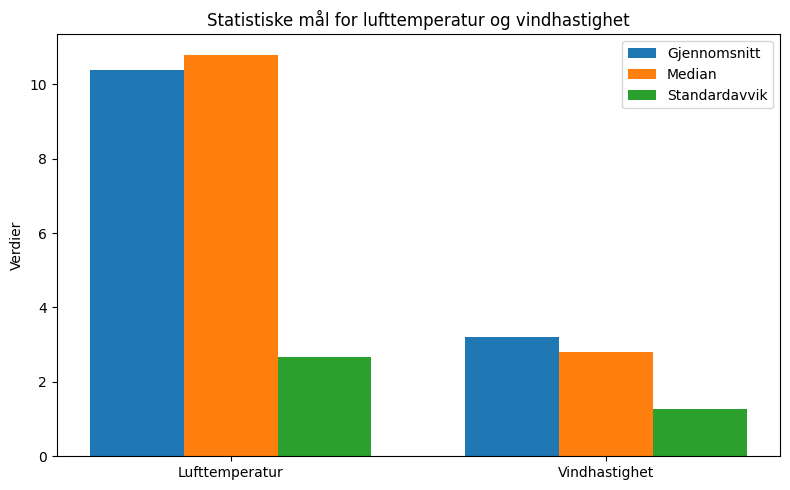

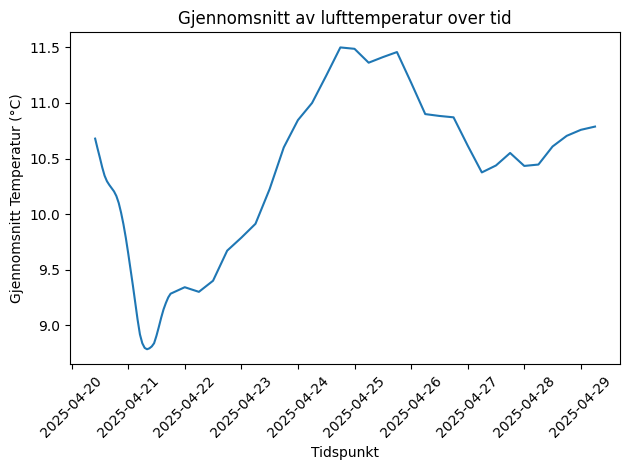

In [5]:
#Oppgave 4
import numpy as np
import matplotlib.pyplot as plt


#Konverterer kolonner til NumPy-arrays
temp_arr = df_cleaned['Lufttemperatur'].to_numpy()
wind_arr = df_cleaned['Vindhastighet'].to_numpy()

stats = {
    'Lufttemperatur': {
        'gjennomsnitt': np.mean(temp_arr),
        'median': np.median(temp_arr),
        'standardavvik': np.std(temp_arr, ddof=1)
    },
    'Vindhastighet': {
        'gjennomsnitt': np.mean(wind_arr),
        'median': np.median(wind_arr),
        'standardavvik': np.std(wind_arr, ddof=1)
    }
}
print("Statistiske mål:")

#Korrelasjonsanalyse mellom lufttemperatur og vindhastighet
korrelasjon = df_cleaned['Lufttemperatur'].corr(df_cleaned['Vindhastighet'])
print(f"Korrelasjon mellom lufttemperatur og vindhastighet: {korrelasjon:.2f}")

#Håndtere skjevheter basert på IQR (Interquatile Range)
Q1 = df_cleaned['Lufttemperatur'].quantile(0.25)
Q3 = df_cleaned['Lufttemperatur'].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = (
    (df_cleaned['Lufttemperatur'] >= Q1 - 1.5 * IQR) &
    (df_cleaned['Lufttemperatur'] <= Q3 + 1.5 * IQR)
)
df_no_outliers = df_cleaned[mask_iqr]
print(f"Antall observasjoner uten skjevheter (temperatur): {len(df_no_outliers)} av {len(df_cleaned)}")


# Forbereder data for plotting med matplotlib
types = list(stats.keys())
means = [stats[t]['gjennomsnitt'] for t in types]
medians = [stats[t]['median'] for t in types]
stds = [stats[t]['standardavvik'] for t in types]

x = range(len(types))
width = 0.25

plt.figure(figsize=(8, 5))

plt.bar([p - width for p in x], means, width=width, label='Gjennomsnitt')
plt.bar(x, medians, width=width, label='Median')
plt.bar([p + width for p in x], stds, width=width, label='Standardavvik')

plt.xticks(x, types)
plt.ylabel('Verdier')
plt.title('Statistiske mål for lufttemperatur og vindhastighet')
plt.legend()
plt.tight_layout()
plt.show()


#Finne og visualiser mønstre i data
window = 24
temp_arr = df_cleaned['Lufttemperatur'].to_numpy()

weights = np.ones(window) / window  
moving_avg = np.convolve(temp_arr, weights, mode='valid')


times = pd.to_datetime(df_cleaned['Tidspunkt']).to_numpy()
times_ma = times[window-1:]


plt.figure()
plt.plot(times_ma, moving_avg)
plt.xlabel('Tidspunkt')
plt.ylabel('Gjennomsnitt Temperatur (°C)')
plt.title('Gjennomsnitt av lufttemperatur over tid')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



